# The Problem:

I am trying to solve a very basic quantum computing problem (No prior QC knowledge needed). I am trying to implement vanilla policy gradient to see if a model can be trained to make any quantum state reach equal superposition. Let me explain:

A random quantum state is in superposition between 0 and 1 with some specific probability. eg, a rough example is 0.2|0> + 0.8|1>. So the probability for 0 is 0.2 and probability for 1 is 0.8. Equal superposition is 0.5|0> + 0.5|1>. So equal probability for 0 and 1. That's it!

Now, the gate sequence that needs to be followed (for any random quantum state) is a measurement and Hadamard gate. This is the sequence that the model needs to learn and I have defined these gates in the method "functions" and I call these gates using the variable "command" as initialised few cells down. 

So I create an "Environment" that randomly initialises a random quantum state and returns that. Then, I create a model and train it according to vanilla PG and I also have a greedy epsilon strategy as "get_exploration_rate". So if you run, the model doesn't seem to converge at all. 


In [1]:
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.models import load_model
from keras.layers import Dense
from keras.optimizers import Adam
from qiskit.quantum_info import random_state
import numpy as np
import random
import matplotlib
import math
import random
from functions import *
import tensorflow as tf
import os
# import objgraph
import sys
import csv
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
'''This is in case you make changes to any python file'''
# %reload_ext autoreload
# %autoreload 2
# from functions import *

'This is in case you make changes to any python file'

In [3]:
r = [0.0,0.0,0.0,0.0,-1.0]
gamma = 0.95
r = np.vstack(r)
d_rw = discounted_reward(r,gamma)
print(d_rw)
d_rw -= np.mean(d_rw)
d_rw /= np.std(d_rw)
print(d_rw)

in discounted reward
[[-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]]
[[ 1.37769927]
 [ 0.72416108]
 [ 0.03622616]
 [-0.68791587]
 [-1.45017064]]


## Creating the environment

In [4]:
class Environment:

    def reset(self):
        state = random_state(2)
        new_state = state_norm(state)
        new_state = np.reshape(new_state.flatten(), (1,1,2))
        return new_state

## The exploration-exploitation rate

In [5]:
# class epsilod_strategy():
#     def __init__(self, start, end, decay):
#         self.start = start
#         self.end = end
#         self.decay = decay
    
def get_exploration_rate(current_step, start, end, decay):

    return max(end, end + (start - end)/math.exp(1.*current_step*decay))

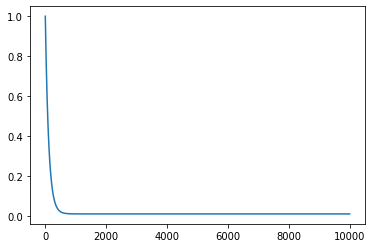

In [6]:
start = 1.0
end = 0.01
decay = 0.009
x = []
for i in range(10000):
    x.append(max(end, get_exploration_rate(i, start, end, decay)))

plt.plot(x)
plt.show()

## The changes I made:

Commenting lines 141 and 142 (basically no standardising the discounting sum of rewards)and changing the formula for "label" in line 150 and replacing it with line 151.

In [31]:
class Agent:
    def __init__(self, state_size, new_state, is_eval=False, model_name=""):
        self.state_size = state_size
        self.action_size = 6 # measurement, CNOT, bit-flip
#         self.memory = deque(maxlen=1000)
        self.inventory = []
        self.model_name = model_name
        self.value = new_state
        self.is_eval = is_eval
        self.done = False
#         self.final_state = [1/math.sqrt(2),1/math.sqrt(2)]

        self.gamma = 0.95
        self.epsilon_start = 1.0
        self.epsilon_end = 0.01
        self.epsilon_decay = 0.009
        self.learning_rate = 0.01
        self.model = self.QC_model()
#         self.model = load_model("model_June_23.h5")
        self.current_step = 0
        self.final_state = np.array([(1/math.sqrt(2))+0j,(1/math.sqrt(2))+0j])

#         self.model = load_model("models/" + model_name) if is_eval else self._model()

# '''
# Method to initialize the network model. It contains 4 fully connected layers, where the last layer gives the
# prbabilities of the gates

# The network will be optmised using adam optimizer. 

# '''
    def QC_model(self):
        model = Sequential()
        model.add(Dense(units=16, input_shape=self.state_size, activation="relu", name='layer1'))
        model.add(Dense(units=32, activation="relu", name='layer2'))
        model.add(Dense(units=8, activation="relu", name='layer3'))
        model.add(Dense(self.action_size, activation="softmax"))
        model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=0.003))
        return model
# '''
# This defines how we select the action using exploration-exploitation rate, we defined above. 

# If random is more than the output of the exploration rate, then we select exploration. Else, exploitation. 
# The exploration rate reduces exponentially and we start exploiting rather than exploring by the last epochs. 
# The rate plot can be assesed through the cell the above

# '''

    def act(self, state, episode): #add episode to reduce the epsilon value
#        action = 0
        rate = get_exploration_rate(episode, self.epsilon_start, self.epsilon_end, self.epsilon_decay)
        if random.random() <= rate:
            options = self.model.predict(state)
            options = np.squeeze(options)
            action =  random.randrange(self.action_size)
        else:
            options = self.model.predict(state)
            options = np.squeeze(options)
    #             print("PROBABILITIES: ", options)
#             print(options)
            action = np.where(options == np.amax(options))[0][0]
#         print("PROBABILITIES OPTIONS: ", options.shape)
#         options = np.squeeze(options)
        return action, options

# '''
# Method to collect data and train the model. 

# '''

    def train(self):
#         column_name = ['episode','time_step','reward', 'projection']
#         with open('reward.csv','a') as fd:
#             write_outfile = csv.writer(fd)
#             write_outfile.writerow(column_name)
        batch_size = 10
        t = 0                   #increment
        states, prob_actions, dlogps, drs, reward_data =[], [], [], [], []  #initialize the list variables
        tr_x, tr_y = [],[]
        avg_reward = []
        reward_sum = 0
        ep_number = 0
        prev_state = None
        new_state = self.value

        while ep_number<1000:
            print("episode number: ",ep_number)
            prev_state = new_state          # Store the initial state
            states.append(new_state)
            action, probs = self.act(new_state, ep_number)        # send the state through the network and get the output
            prob_actions.append(probs)
            y = np.zeros([self.action_size])
            new_state = np.squeeze(new_state)
            y[action] = 1                         # one hot encoding for the actions
            new_state = eval(command[action])       # run the command according to the action predicted by the network
            if(np.allclose(new_state,self.final_state)):    # if the state is equal to the final state
                rw = 1
                drs.append(rw)
                reward_sum+=rw
                self.done = True                # set done = True so that we can train the network on the data
            if(t<4 and not np.allclose(new_state,self.final_state)):  # when we are NOT done with the episode and want to store the reward
                rw = reward(new_state, self.final_state)
                drs.append(rw)
                reward_sum+=rw
            elif(t==4):                      # when we have reached the final time stamp for the episode
                self.done = True
                if not np.allclose(new_state, self.final_state):
                    rw = -1
                    drs.append(rw)
                    reward_sum+=rw
#             reward_data = [ep_number, t, reward_sum, proj]
#             with open('reward.csv','a') as fd:
#                 write_outfile = csv.writer(fd)
#                 write_outfile.writerow(reward_data)
#            with open('reward.csv','a') as fd:
#                write_outfile = csv.writer(fd)
#                write_outfile.writerow((reward_sum))
            new_state = np.reshape(new_state, (1,1,2))   #get the shape of state according to keras requirements
#             print("State: ", new_state)
#             proj = projection(new_state, self.final_state)
#             print("projection: ", proj)
#             proj_data.append(proj)
            print("reward till now: ",reward_sum)
#            print("probs: ", probs.shape)
            dlogps.append(np.array(y).astype('float32') * probs)  # multiply one hot encoding to the probabilities
#             print("dlogps before time step: ",(dlogps[0].shape))
            del(probs, action) 
            print("time step: ",t)
            t+=1
            if(self.done):                         #### Done State
                ep_number+=1
                ep_x = np.vstack(states)                     # vertially stack the states we used to train the network on
#                 print("length of states: ", len(ep_x))
                ep_dlogp = np.vstack(dlogps)                 # vertically stack the action probabilities we got for the states above
#                 print("dlogps: ", len(dlogps))
                ep_reward = np.vstack(drs)                   # vertically stack the rewards corresponding to the state-action pairs
                disc_rw = discounted_reward(ep_reward,self.gamma)
                print("disc_rw: ", (disc_rw))
#                 print("ep_dlogp: ", (ep_dlogp[0].shape))
                disc_rw = disc_rw.astype('float32')
#                 disc_rw -= np.mean(disc_rw)
#                 disc_rw /= np.std(disc_rw)

                tr_y_len = len(ep_dlogp)
#                 print("ep_dlogp: ", len(ep_dlogp))
                ep_dlogp*=disc_rw
#                states, drs =[], []
                if ep_number % batch_size == 0:

#                     input_tr_y = prob_actions - self.learning_rate * ep_dlogp
                    input_tr_y = ep_dlogp
                    input_tr_y = np.reshape(input_tr_y, (tr_y_len,1,6))

                    self.model.train_on_batch(ep_x, input_tr_y)
                    dlogps, drs, states, prob_actions,proj_data, reward_data = [],[],[],[],[],[]
                avg_reward.append((reward_sum))
#                 if(ep_number%1000==0):
#                     self.model.save("model_ep{:}.h5".format(ep_number))
#                 if len(avg_reward)>100: avg_reward.pop(0)
                print('Episode {:} reward {:.2f}, Last 30ep Avg. rewards {:.2f}.'.format(
                    ep_number,reward_sum,avg_reward[ep_number-1]))
                env = Environment()
                state = env.reset()
                t=0
                self.done=False
#                 objgraph.show_most_common_types()

        return avg_reward

In [32]:
command = ['bit_flip_X(new_state)',
           'bit_flip_Y(new_state)',
           'hadamard_X(new_state)',
           'hadamard_Y(new_state)',
           'measurement(new_state[0],new_state[1])',
           'nothing(new_state)']

In [33]:
# def get_exploration_rate(current_step, start, end, decay):
        
#         return end + (start - end)/math.exp(1.*current_step*decay)

In [34]:
env = Environment()
state = env.reset()

agent = Agent(state[0].shape, state)
final_reward = agent.train()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: The `random_state` function is deprecated as of 0.13.0, and will be removed no earlier than 3 months after that release date. You should use the `random_statevector` function instead.
  after removing the cwd from sys.path.


episode number:  0
reward till now:  0.0
time step:  0
episode number:  0
reward till now:  0.0
time step:  1
episode number:  0
reward till now:  0.0
time step:  2
episode number:  0
reward till now:  0.0
time step:  3
episode number:  0
reward till now:  -1.0
time step:  4
in discounted reward
disc_rw:  [[-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]]
Episode 1 reward -1.00, Last 30ep Avg. rewards -1.00.
episode number:  1
reward till now:  -1.0
time step:  0
episode number:  1
reward till now:  -1.0
time step:  1
episode number:  1
reward till now:  -1.0
time step:  2
episode number:  1
reward till now:  -1.0
time step:  3
episode number:  1
reward till now:  -2.0
time step:  4
in discounted reward
disc_rw:  [[-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]]
Episode 2 reward -2.00, Last 30ep Avg. rewards -2.00.
episode number:  2
reward till now:  -2.0
time 

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/constant_op.py:96: ComplexWarning: Casting complex values to real discards the imaginary part
  return ops.EagerTensor(value, ctx.device_name, dtype)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: The `random_state` function is deprecated as of 0.13.0, and will be removed no earlier than 3 months after that release date. You should use the `random_statevector` function instead.
  after removing the cwd from sys.path.


Episode 10 reward -6.00, Last 30ep Avg. rewards -6.00.
episode number:  10
reward till now:  -5.0
time step:  0
in discounted reward
disc_rw:  [[1]]
Episode 11 reward -5.00, Last 30ep Avg. rewards -5.00.
episode number:  11
reward till now:  -4.0
time step:  0
in discounted reward
disc_rw:  [[1]
 [1]]
Episode 12 reward -4.00, Last 30ep Avg. rewards -4.00.
episode number:  12
reward till now:  -4.0
time step:  0
episode number:  12
reward till now:  -4.0
time step:  1
episode number:  12
reward till now:  -4.0
time step:  2
episode number:  12
reward till now:  -4.0
time step:  3
episode number:  12
reward till now:  -3.0
time step:  4
in discounted reward
disc_rw:  [[1.        ]
 [1.        ]
 [0.81450625]
 [0.857375  ]
 [0.9025    ]
 [0.95      ]
 [1.        ]]
Episode 13 reward -3.00, Last 30ep Avg. rewards -3.00.
episode number:  13
reward till now:  -3.0
time step:  0
episode number:  13
reward till now:  -3.0
time step:  1
episode number:  13
reward till now:  -3.0
time step:  2
e

disc_rw:  [[-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]]
Episode 31 reward -17.00, Last 30ep Avg. rewards -17.00.
episode number:  31
reward till now:  -17.0
time step:  0
episode number:  31
reward till now:  -17.0
time step:  1
episode number:  31
reward till now:  -17.0
time step:  2
episode number:  31
reward till now:  -17.0
time step:  3
episode number:  31
reward till now:  -18.0
time step:  4
in discounted reward
disc_rw:  [[-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]]
Episode 32 reward -18.00, Last 30ep Avg. rewards -18.00.
episode number:  32
reward till now:  -18.0
time step:  0
episode number:  32
reward till now:  -18.0
time step:  1
episode number:  32
reward till now:  -18.0
time step:  2
episode number:  32
reward till now:  -18.0
time step:  3
episode number:  32
reward till now:  -19.0
time step:  4
in discounted reward
disc_rw:  [[-0.81

reward till now:  -33.0
time step:  4
in discounted reward
disc_rw:  [[-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]]
Episode 53 reward -33.00, Last 30ep Avg. rewards -33.00.
episode number:  53
reward till now:  -33.0
time step:  0
episode number:  53
reward till now:  -33.0
time step:  1
episode number:  53
reward till now:  -33.0
time step:  2
episode number:  53
reward till now:  -33.0
time step:  3
episode number:  53
reward till now:  -34.0
time step:  4
in discounted reward
disc_rw:  [[-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]]
Episode 54 reward -34.00, 

episode number:  73
reward till now:  -51.0
time step:  2
episode number:  73
reward till now:  -51.0
time step:  3
episode number:  73
reward till now:  -52.0
time step:  4
in discounted reward
disc_rw:  [[-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]]
Episode 74 reward -52.00, Last 30ep Avg. rewards -52.00.
episode number:  74
reward till now:  -52.0
time step:  0
episode number:  74
reward till now:  -52.0
time step:  1
episode number:  74
reward till now:  -52.0
time step:  2
episode number:  74
reward till now:  -52.0
time step:  3
episode number:  74
reward till now:  -53.0
time step:  4
in discounted reward
disc_rw:  [[-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025  

reward till now:  -64.0
time step:  4
in discounted reward
disc_rw:  [[-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [ 0.95      ]
 [ 1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]]
Episode 96 reward -64.00, Last 30ep Avg. rewards -64.00.
episode number:  96
reward till now:  -64.0
time step:  0
episode number:  96
reward till now:  -64.0
time step:  1
episode number:  96
reward till now:  -64.0
time step:  2
episode number:  96
reward till now:  -64.0
time step:  3
episode number:  96
reward till now:  -65.0
time step:  4
in discounted reward
disc_rw:  [[-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [ 0.95      ]
 [ 1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025   

reward till now:  -83.0
time step:  4
in discounted reward
disc_rw:  [[-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]]
Episode 117 reward -83.00, Last 30ep Avg. rewards -83.00.
episode number:  117
reward till now:  -83.0
time step:  0
episode number:  117
reward till now:  -83.0
time step:  1
episode number:  117
reward till now:  -83.0
time step:  2
episode number:  117
reward till now:  -83.0
time step:  3
episode number:  117
reward till now:  -84.0
time step:  4
in discounted reward
disc_rw:  [[-0.81450625]
 [-0.8

disc_rw:  [[0.9025]
 [0.95  ]
 [1.    ]
 [1.    ]]
Episode 142 reward -90.00, Last 30ep Avg. rewards -90.00.
episode number:  142
reward till now:  -89.0
time step:  0
in discounted reward
disc_rw:  [[0.9025]
 [0.95  ]
 [1.    ]
 [1.    ]
 [1.    ]]
Episode 143 reward -89.00, Last 30ep Avg. rewards -89.00.
episode number:  143
reward till now:  -88.0
time step:  0
in discounted reward
disc_rw:  [[0.9025]
 [0.95  ]
 [1.    ]
 [1.    ]
 [1.    ]
 [1.    ]]
Episode 144 reward -88.00, Last 30ep Avg. rewards -88.00.
episode number:  144
reward till now:  -88.0
time step:  0
episode number:  144
reward till now:  -88.0
time step:  1
episode number:  144
reward till now:  -88.0
time step:  2
episode number:  144
reward till now:  -88.0
time step:  3
episode number:  144
reward till now:  -89.0
time step:  4
in discounted reward
disc_rw:  [[ 0.9025    ]
 [ 0.95      ]
 [ 1.        ]
 [ 1.        ]
 [ 1.        ]
 [ 1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.  

reward till now:  -99.0
time step:  4
in discounted reward
disc_rw:  [[-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]]
Episode 169 reward -99.00, Last 30ep Avg. rewards -99.00.
episode number:  169
reward till now:  -99.0
time step:  0
episode number:  169
reward till now:  -99.0
time step:  1
episode number:  169
reward till now:  -99.0
time step:  2
episode number:  169

reward till now:  -62.0
time step:  2
episode number:  218
reward till now:  -62.0
time step:  3
episode number:  218
reward till now:  -63.0
time step:  4
in discounted reward
disc_rw:  [[ 1.        ]
 [ 1.        ]
 [ 1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]]
Episode 219 reward -63.00, Last 30ep Avg. rewards -63.00.
episode number:  219
reward till now:  -63.0
time step:  0
episode number:  219
reward till now:  -63.0
time step:  1
episode number:  219
reward till now:  -63.0
time step:  2
episode number:  219
reward till now:  -63.0
time step:  3
episode number:  219
re

reward till now:  -83.0
time step:  4
in discounted reward
disc_rw:  [[-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]]
Episode 239 reward -83.00, Last 30ep Avg. rewards -83.00.
episode number:  239
reward till now:  -83.0
time step:  0
episode number:  239
reward till now:  -83.0
time step:  1
episode number:  239
reward till now:  -83.0
time step:  2
episode number:  239

reward till now:  -103.0
time step:  2
episode number:  259
reward till now:  -103.0
time step:  3
episode number:  259
reward till now:  -104.0
time step:  4
in discounted reward
disc_rw:  [[-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]]
Episode 260 reward -104.00, Last 30ep Avg. rewards -104.00.

Episode 280 reward -124.00, Last 30ep Avg. rewards -124.00.
episode number:  280
reward till now:  -124.0
time step:  0
episode number:  280
reward till now:  -124.0
time step:  1
episode number:  280
reward till now:  -124.0
time step:  2
episode number:  280
reward till now:  -124.0
time step:  3
episode number:  280
reward till now:  -125.0
time step:  4
in discounted reward
disc_rw:  [[-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]]
Episode 281 reward -125.00, Last 30ep Avg. rewards -125.00.
episode number:  281
reward till now:  -125.0
time step:  0
episode number:  281
reward till now:  -125.0
time step:  1
episode number:  281
reward till now:  -125.0
time step:  2
episode number:  281
reward till now:  -125.0
time step:  3
episode number:  281
reward till now:  -126.0
time step:  4
in discounted reward
disc_rw:  [[-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.  

reward till now:  -143.0
time step:  2
episode number:  299
reward till now:  -143.0
time step:  3
episode number:  299
reward till now:  -144.0
time step:  4
in discounted reward
disc_rw:  [[-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]]
Episode 300 reward -144.00, Last 30ep Avg. rewards -144.00.

disc_rw:  [[-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]]
Episode 319 reward -163.00, Last 30ep Avg. rewards -163.00.
episode number:  319
reward till now:  -163.0
time step:  0
episode number:  319
reward till now:  -163.0
time step:  1
episode number:  319
reward till now:  -163.0
time step:  2
episode number:  319
reward till now:  -163.0
time step:  3
episode number

time step:  3
episode number:  335
reward till now:  -180.0
time step:  4
in discounted reward
disc_rw:  [[-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]]
Episode 336 reward -180.00, Last 30ep Avg. rewards -180.00.
episode number:  336
reward till now:  -179.0
time step:  0
in discounted reward
disc_rw:  [[-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.   

reward till now:  -187.0
time step:  1
episode number:  359
reward till now:  -187.0
time step:  2
episode number:  359
reward till now:  -187.0
time step:  3
episode number:  359
reward till now:  -188.0
time step:  4
in discounted reward
disc_rw:  [[-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]]

reward till now:  -199.0
time step:  0
episode number:  383
reward till now:  -199.0
time step:  1
episode number:  383
reward till now:  -199.0
time step:  2
episode number:  383
reward till now:  -199.0
time step:  3
episode number:  383
reward till now:  -200.0
time step:  4
in discounted reward
disc_rw:  [[-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]]
Episode 384 reward -200.00, Last 30ep Avg. rewards -200.00.
episode number:  384
reward till now:  -200.0
time step:  0
episode number:  384
reward till now:  -200.0
time step:  1
episode number:  384
reward till now:  -200.0
time step:  2
episode number:  384
reward till now:  -200.0
time step:  3
episode number:  384
reward till now:  -201.0
time step:  4
in discounted reward
disc_rw:

reward till now:  -219.0
time step:  1
episode number:  403
reward till now:  -219.0
time step:  2
episode number:  403
reward till now:  -219.0
time step:  3
episode number:  403
reward till now:  -220.0
time step:  4
in discounted reward
disc_rw:  [[-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]]
Episode 404 reward -220.00, Last 30ep Avg. rewards -220.00.
episode number:  404
reward till now:  -220.0
time step:  0
episode number:  404
reward till now:  -220.0
time step:  1
episode number:  404
reward till now:  -220.0
time step:  2
episode number:  404
reward till now:  -220.0
time step:  3
episode number:  404
reward till now:  -221.0
time step:  4
in discounted reward
disc_rw:  [[-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      

reward till now:  -238.0
time step:  1
episode number:  422
reward till now:  -238.0
time step:  2
episode number:  422
reward till now:  -238.0
time step:  3
episode number:  422
reward till now:  -239.0
time step:  4
in discounted reward
disc_rw:  [[-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]]
Episode 423 reward -239.00, Last 30ep Avg. rewards -239.00.
episode number:  423
reward till now:  -239.0
time step:  0
episode number:  423
reward till now:  -239.0
time step:  1
episode number:  423
reward till now:  -239.0
time step:  2
episode number:  423
reward till now:  -239.0
time step:  3
episode number:  423
reward till now:  -240.0
time step:  4
in discounted reward
disc_rw:  [[-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      

reward till now:  -249.0
time step:  0
in discounted reward
disc_rw:  [[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]]
Episode 447 reward -249.00, Last 30ep Avg. rewards -249.00.
episode number:  447
reward till now:  -248.0
time step:  0
in discounted reward
disc_rw:  [[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]]
Episode 448 reward -248.00, Last 30ep Avg. rewards -248.00.
episode number:  448
reward till now:  -247.0
time step:  0
in discounted reward
disc_rw:  [[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]]
Episode 449 reward -247.00, Last 30ep Avg. rewards -247.00.
episode number:  449
reward till now:  -246.0
time step:  0
in discounted reward
disc_rw:  [[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]]
Episode 450 reward -246.00, Last 30ep Avg. rewards -246.00.
episode number:  450
reward till now:  -245.0
time step:  0
in discounted reward
disc_rw:  [[1]]
Episode 451 reward -245.00, Last 30ep Avg. rewards -245.00.
episode number:  451
reward till now:  -244.0
time step:  0
in discounted reward
disc_

reward till now:  -181.0
time step:  0
in discounted reward
disc_rw:  [[1]
 [1]
 [1]
 [1]
 [1]]
Episode 515 reward -181.00, Last 30ep Avg. rewards -181.00.
episode number:  515
reward till now:  -180.0
time step:  0
in discounted reward
disc_rw:  [[1]
 [1]
 [1]
 [1]
 [1]
 [1]]
Episode 516 reward -180.00, Last 30ep Avg. rewards -180.00.
episode number:  516
reward till now:  -179.0
time step:  0
in discounted reward
disc_rw:  [[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]]
Episode 517 reward -179.00, Last 30ep Avg. rewards -179.00.
episode number:  517
reward till now:  -178.0
time step:  0
in discounted reward
disc_rw:  [[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]]
Episode 518 reward -178.00, Last 30ep Avg. rewards -178.00.
episode number:  518
reward till now:  -177.0
time step:  0
in discounted reward
disc_rw:  [[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]]
Episode 519 reward -177.00, Last 30ep Avg. rewards -177.00.
episode number:  519
reward till now:  -176.0
time step:  0
in discounted reward
disc_

Episode 538 reward -194.00, Last 30ep Avg. rewards -194.00.
episode number:  538
reward till now:  -194.0
time step:  0
episode number:  538
reward till now:  -194.0
time step:  1
episode number:  538
reward till now:  -194.0
time step:  2
episode number:  538
reward till now:  -194.0
time step:  3
episode number:  538
reward till now:  -195.0
time step:  4
in discounted reward
disc_rw:  [[-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.8145

reward till now:  -213.0
time step:  2
episode number:  557
reward till now:  -213.0
time step:  3
episode number:  557
reward till now:  -214.0
time step:  4
in discounted reward
disc_rw:  [[-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]]
Episode 558 reward -214.00, Last 30ep Avg. rewards -214.00.
episode number:  558
reward till now:  -214.0
time step:  0
episode number:  558
reward till now:  -214.0
time step:  1
episode number:  558
reward t

reward till now:  -233.0
time step:  2
episode number:  577
reward till now:  -233.0
time step:  3
episode number:  577
reward till now:  -234.0
time step:  4
in discounted reward
disc_rw:  [[-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]]
Episode 578 reward -234.00, Last 30ep Avg. rewards -234.00.
episode number:  578
reward till now:  -234.0
time step:  0
episode number:  578
reward till now:  -234.0
time step:  1
episode number:  578
reward t

reward till now:  -252.0
time step:  2
episode number:  596
reward till now:  -252.0
time step:  3
episode number:  596
reward till now:  -253.0
time step:  4
in discounted reward
disc_rw:  [[-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]]
Episode 597 reward -253.00, Last 30ep Avg. rewards -253.00.
episode number:  597
reward till now:  -253.0
time step:  0
episode number:  597
reward till now:  -253.0
time step:  1
episode number:  597
reward till now:  -253.0
time step:  2
episode number:  597
reward till now:  -253.

reward till now:  -270.0
time step:  2
episode number:  614
reward till now:  -270.0
time step:  3
episode number:  614
reward till now:  -271.0
time step:  4
in discounted reward
disc_rw:  [[-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]]
Episode 615 reward -271.00, Last 30ep Avg. rewards -271.00.
episode number:  615
reward till now:  -271.0
time step:  0
episode number:  615
reward till now:  -271.0
time step:  1
episode number:  615
reward till now:  -271.0
time step:  2
episode number:  615
reward till now:  -271.0
time step:  3
episode number:  615
reward till now:  -272.0
time step:  4
in discounted reward
disc_rw:  [[-0.81450625]
 [-0.857375  ]
 [-0.9025    

reward till now:  -288.0
time step:  1
episode number:  632
reward till now:  -288.0
time step:  2
episode number:  632
reward till now:  -288.0
time step:  3
episode number:  632
reward till now:  -289.0
time step:  4
in discounted reward
disc_rw:  [[-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]]
Episode 633 reward -289.00, Last 30ep Avg. rewards -289.00.
episode number:  633
reward till now:  -289.0
time step:  0
episode number:  633
reward till now:  -289.0
time step:  1
episode number:  633
reward till now:  -289.0
time step:  2
episode number:  633
reward till now:  -289.0
time step:  3
episode number:  633
reward till now:  -290.0
time step:  4
in discounted reward
disc_rw:  [[-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      

time step:  4
in discounted reward
disc_rw:  [[-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]]
Episode 650 reward -306.00, Last 30ep Avg. rewards -306.00.
episode number:  650
reward till now:  -306.0
time step:  0
episode number:  650
reward till now:  -306.0
time step:  1
episode number:  650
rew

time step:  3
episode number:  670
reward till now:  -327.0
time step:  4
in discounted reward
disc_rw:  [[-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]]
Episode 671 reward -327.00, Last 30ep Avg. rewards -327.00.
episode number:  671
reward till now:  -327.0
time step:  0
episode number:  671
reward till now:  -327.0
time step:  1
episode number:  671
reward till now:  -327.0
time step:  2
episode number:  671
reward till now:  -327.0
time step:  3
episode number:  671
reward till now:  -328.0
time step:  4
in discounted reward
disc_rw:  [[-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]]
Episode 672 reward -328.00, Last 30ep Avg. rewards -328.00.
episode number:  672
reward till now:  -328.0
time step:  0
episode number:  672
reward till now:  -328.0
time step:  1
episode number:  672
reward till now:  -328.0
time step:  2
episode number:  672
reward till now:

reward till now:  -345.0
time step:  2
episode number:  689
reward till now:  -345.0
time step:  3
episode number:  689
reward till now:  -346.0
time step:  4
in discounted reward
disc_rw:  [[-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]]
Episode 690 reward -346.00, Last 30ep Avg. rewards -346.00.

time step:  4
in discounted reward
disc_rw:  [[-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]]
Episode 711 reward -361.00, Last 30ep Avg. rewards -361.00.
episode number:  711
reward till now:  -361.0
time step:  0
episode number:  711
reward till now:  -361.0
time step:  1
episode number:  711
reward till now:  -361.0
time step:  2
episode number:  711
reward till now:  -361.0
time step:  3
episode number:  711
reward till now:  -362.0
time step:  4
in discounted reward
disc_rw:  [[-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]]
Episode 712 reward -362.00, Last 30ep Avg. rewards -362.00.
episode number:  712
reward till now:  -362.0
time step:  0
episode number:  712
reward till now:  -362.0
time step:  1
episode number:  712
reward till now:  -362.0
time step:  2
episode number:  712
reward till now:  -362.0
time step:  3
episode number:  712
reward till now:

disc_rw:  [[1]
 [1]
 [1]
 [1]]
Episode 764 reward -318.00, Last 30ep Avg. rewards -318.00.
episode number:  764
reward till now:  -317.0
time step:  0
in discounted reward
disc_rw:  [[1]
 [1]
 [1]
 [1]
 [1]]
Episode 765 reward -317.00, Last 30ep Avg. rewards -317.00.
episode number:  765
reward till now:  -316.0
time step:  0
in discounted reward
disc_rw:  [[1]
 [1]
 [1]
 [1]
 [1]
 [1]]
Episode 766 reward -316.00, Last 30ep Avg. rewards -316.00.
episode number:  766
reward till now:  -315.0
time step:  0
in discounted reward
disc_rw:  [[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]]
Episode 767 reward -315.00, Last 30ep Avg. rewards -315.00.
episode number:  767
reward till now:  -314.0
time step:  0
in discounted reward
disc_rw:  [[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]]
Episode 768 reward -314.00, Last 30ep Avg. rewards -314.00.
episode number:  768
reward till now:  -313.0
time step:  0
in discounted reward
disc_rw:  [[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]]
Episode 769 reward -313.00, Last 3

time step:  0
episode number:  818
reward till now:  -276.0
time step:  1
episode number:  818
reward till now:  -276.0
time step:  2
episode number:  818
reward till now:  -276.0
time step:  3
episode number:  818
reward till now:  -277.0
time step:  4
in discounted reward
disc_rw:  [[ 1.        ]
 [ 1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]
 [-0.81450625]
 [-0.857375  ]
 [-0.9025    ]
 [-0.95      ]
 [-1.        ]]
Episode 819 reward -277.00, Last 30ep Avg. rewards -277.00.
episode number:  819
reward till now:  -277.0
time step:  0
episode number:  819
reward till now:  

disc_rw:  [[1]
 [1]]
Episode 872 reward -234.00, Last 30ep Avg. rewards -234.00.
episode number:  872
reward till now:  -233.0
time step:  0
in discounted reward
disc_rw:  [[1]
 [1]
 [1]]
Episode 873 reward -233.00, Last 30ep Avg. rewards -233.00.
episode number:  873
reward till now:  -232.0
time step:  0
in discounted reward
disc_rw:  [[1]
 [1]
 [1]
 [1]]
Episode 874 reward -232.00, Last 30ep Avg. rewards -232.00.
episode number:  874
reward till now:  -231.0
time step:  0
in discounted reward
disc_rw:  [[1]
 [1]
 [1]
 [1]
 [1]]
Episode 875 reward -231.00, Last 30ep Avg. rewards -231.00.
episode number:  875
reward till now:  -230.0
time step:  0
in discounted reward
disc_rw:  [[1]
 [1]
 [1]
 [1]
 [1]
 [1]]
Episode 876 reward -230.00, Last 30ep Avg. rewards -230.00.
episode number:  876
reward till now:  -229.0
time step:  0
in discounted reward
disc_rw:  [[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]]
Episode 877 reward -229.00, Last 30ep Avg. rewards -229.00.
episode number:  877
reward till n

disc_rw:  [[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]]
Episode 940 reward -166.00, Last 30ep Avg. rewards -166.00.
episode number:  940
reward till now:  -165.0
time step:  0
in discounted reward
disc_rw:  [[1]]
Episode 941 reward -165.00, Last 30ep Avg. rewards -165.00.
episode number:  941
reward till now:  -164.0
time step:  0
in discounted reward
disc_rw:  [[1]
 [1]]
Episode 942 reward -164.00, Last 30ep Avg. rewards -164.00.
episode number:  942
reward till now:  -163.0
time step:  0
in discounted reward
disc_rw:  [[1]
 [1]
 [1]]
Episode 943 reward -163.00, Last 30ep Avg. rewards -163.00.
episode number:  943
reward till now:  -162.0
time step:  0
in discounted reward
disc_rw:  [[1]
 [1]
 [1]
 [1]]
Episode 944 reward -162.00, Last 30ep Avg. rewards -162.00.
episode number:  944
reward till now:  -161.0
time step:  0
in discounted reward
disc_rw:  [[1]
 [1]
 [1]
 [1]
 [1]]
Episode 945 reward -161.00, Last 30ep Avg. rewards -161.00.
episode number:  945
reward till now:  -160.

In [35]:
len(final_reward)

1000

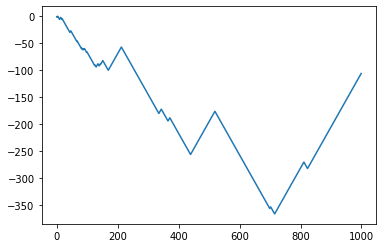

In [36]:
plt.plot(final_reward)
plt.show()

In [26]:
# agent.model.save("model_June_23.h5")